##سوال اول

installing the dependencies:

In [ ]:
!pip install control
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.0 MB/s eta 0:00:00


تعریف سیستم انتقال و سیستم با تاخیر

In [ ]:
import control
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control
from scipy import signal

num = [1, 0]
den = [1, 1]
system = control.TransferFunction(num, den)

delay = 0.7
n_pade = 3
num_delay, den_delay = control.pade(delay, n_pade)
system_delay = control.TransferFunction(num_delay, den_delay)
system_with_delay = system * system_delay


طراحی کنترل‌کننده به روش زیگلر-نیکلز

In [ ]:
def zn_pid_tuning(delayed_plant_tf):
    gm, pm, w_gain, w_phase = control.margin(delayed_plant_tf)
    ultimate_gain = gm
    ultimate_period = 2 * np.pi / w_gain

    Kp = 0.6 * ultimate_gain
    Ti = ultimate_period / 2
    Td = ultimate_period / 8

    Ki = Kp / Ti
    Kd = Kp * Td

    return Kp, Ki, Kd


طراحی کنترل‌کننده فازی

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def build_fuzzy_pid_controller():
    e_range = np.linspace(-1, 1, 7)
    de_range = np.linspace(-1, 1, 7)
    out_range = np.linspace(-1, 1, 7)

    error_input = ctrl.Antecedent(e_range, 'error')
    delta_input = ctrl.Antecedent(de_range, 'delta_error')
    pid_output = ctrl.Consequent(out_range, 'output')

    membership_functions = ['NB', 'NM', 'NS', 'ZE', 'PS', 'PM', 'PB']
    error_input.automf(names=membership_functions)
    delta_input.automf(names=membership_functions)
    pid_output.automf(names=membership_functions)

    rules = []
    for i in range(len(membership_functions)):
        for j in range(len(membership_functions)):
            out_idx = min(6, max(0, i + j - 3))
            rule = ctrl.Rule(
                error_input[membership_functions[i]] &
                delta_input[membership_functions[j]],
                pid_output[membership_functions[out_idx]]
            )
            rules.append(rule)

    fuzzy_control_system = ctrl.ControlSystem(rules)
    fuzzy_controller = ctrl.ControlSystemSimulation(fuzzy_control_system)
    return fuzzy_controller

fuzzy_pid = build_fuzzy_pid_controller()

fuzzy_response = np.zeros_like(t)
previous_error = 0.0
time_step = t[1] - t[0] if len(t) > 1 else 1.0

for k in range(len(t) - 1):
    current_error = 1.0 - fuzzy_response[k - 1] if k != 0 else 1.0
    error_derivative = (current_error - previous_error) / time_step

    fuzzy_pid.input['error'] = np.clip(current_error, -1.0, 1.0)
    fuzzy_pid.input['delta_error'] = np.clip(error_derivative, -1.0, 1.0)
    fuzzy_pid.compute()

    control_signal = fuzzy_pid.output['output']
    fuzzy_response[k + 1] = fuzzy_response[k] + control_signal * time_step
    previous_error = current_error


 مقایسه عملکرذ

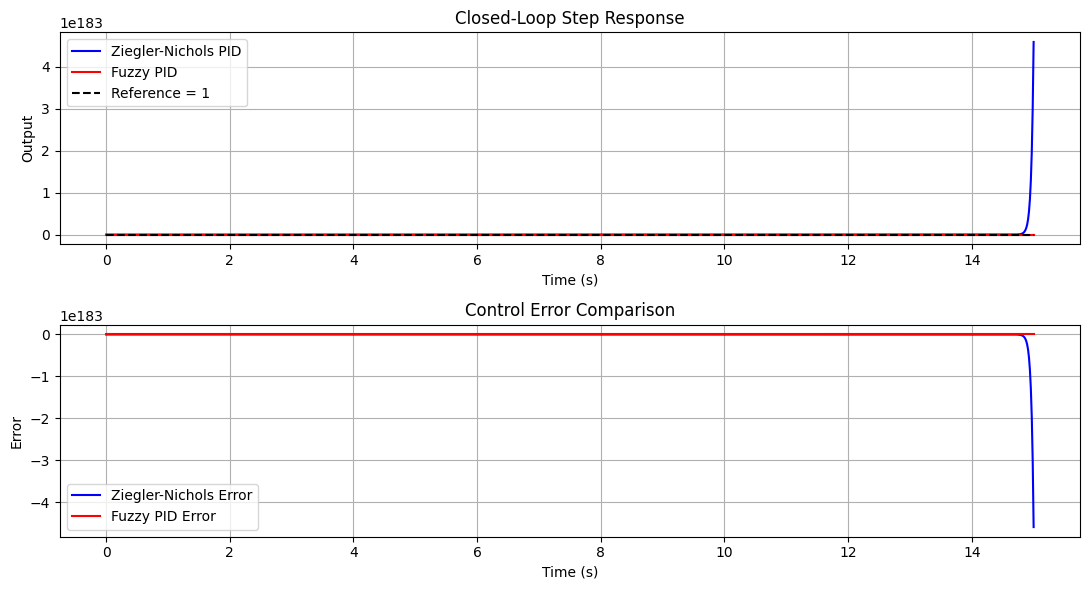

In [ ]:
def compute_performance_metrics(response, time_vals):
    final_value = response[-1]
    peak_output = np.max(response)
    overshoot = 0.0
    settling_time = None
    rise_time = None

    if final_value != 0:
        overshoot = (peak_output - final_value) / final_value * 100

    settling_band = 0.02 * final_value
    for idx in range(len(response)):
        if abs(response[idx] - final_value) <= settling_band:
            settling_time = time_vals[idx]
            break

    if (final_value - response[0]) != 0:
        normalized_resp = (response - response[0]) / (final_value - response[0])
    else:
        normalized_resp = response

    start_t, end_t = None, None
    for idx, val in enumerate(normalized_resp):
        if start_t is None and val >= 0.1:
            start_t = time_vals[idx]
        if val >= 0.9:
            end_t = time_vals[idx]
            break

    if start_t is not None and end_t is not None:
        rise_time = end_t - start_t

    return {
        'Overshoot (%)': overshoot,
        'Settling Time (s)': settling_time,
        'Rise Time (s)': rise_time,
        'Peak': peak_output,
        'Steady State': final_value
    }


zn_metrics = compute_performance_metrics(y_zn, t)
fuzzy_metrics = compute_performance_metrics(fuzzy_response, t)

plt.figure(figsize=(11, 6))

plt.subplot(2, 1, 1)
plt.plot(t, y_zn, label='Ziegler-Nichols PID', color='blue')
plt.plot(t, fuzzy_response, label='Fuzzy PID', color='red')
plt.plot(t, np.ones_like(t), '--', color='black', label='Reference = 1')
plt.title('Closed-Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
zn_error = 1.0 - y_zn
fuzzy_error = 1.0 - fuzzy_response
plt.plot(t, zn_error, label='Ziegler-Nichols Error', color='blue')
plt.plot(t, fuzzy_error, label='Fuzzy PID Error', color='red')
plt.title('Control Error Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


چاپ نتایج

In [ ]:
print("Ziegler-Nichols PID Performance:")
for metric_name, value in zn_metrics.items():
    print(f"  {metric_name}: {value:.3f}")

print("\nFuzzy PID Performance:")
for metric_name, value in fuzzy_metrics.items():
    print(f"  {metric_name}: {value:.3f}")

print("\nFuzzy PID Output:")
step_size = max(1, len(t) // 5)
for step in range(0, len(t), step_size):
    print(f"Time: {t[step]:.2f}s, Fuzzy PID Output: {fuzzy_response[step]:.3f}")

print("\nZiegler-Nichols PID:")
print(f"  Kp: {Kp_val:.3f}")
print(f"  Ki: {Ki_val:.3f}")
print(f"  Kd: {Kd_val:.3f}")


Ziegler-Nichols PID Performance:
  Overshoot (%): 0.000
  Settling Time (s): 15.000
  Rise Time (s): 0.075
  Peak: 4592211170165974954250138772372781565427208866596334421584345087098144675865087285390045821139879494524170488464976127728927252009576820793259427555974791966881117168276022537844948992.000
  Steady State: 4592211170165974954250138772372781565427208866596334421584345087098144675865087285390045821139879494524170488464976127728927252009576820793259427555974791966881117168276022537844948992.000

Fuzzy PID Performance:
  Overshoot (%): 0.000
  Settling Time (s): 7.252
  Rise Time (s): 4.580
  Peak: 1.005
  Steady State: 1.005

Fuzzy PID Output:
Time: 0.00s, Fuzzy PID Output: 0.000
Time: 3.00s, Fuzzy PID Output: 0.761
Time: 6.01s, Fuzzy PID Output: 0.954
Time: 9.01s, Fuzzy PID Output: 0.992
Time: 12.01s, Fuzzy PID Output: 0.997

Ziegler-Nichols PID:
  Kp: 0.613
  Ki: 0.941
  Kd: 0.100
